#Notebook for link prediciton analysis
##Coursework 2015, HSE - DataSci
###Sergey Korolev

####First attempt, similarity based algorithms

####Networks used:
1. UciNet data - http://vlado.fmf.uni-lj.si/pub/networks/data/UciNet/UciData.htm
2. Pajek datasets - http://vlado.fmf.uni-lj.si/pub/networks/data/default.htm
3. ND - http://www3.nd.edu/~networks/resources.htm (possibly already in pajek ds)
4. Alex Arenas - http://deim.urv.cat/~alexandre.arenas/data/welcome.htm
5. Stanford nets - http://snap.stanford.edu/data/

Really hope to sift through them or just write some interface to load them into networkx to work with them.

#####All theoretical notes on the algroithms are quoted directly from Linyuan Lü, Tao Zhou, Link prediction in complex networks: A survey, Physica A 390, 2011

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import operator
import pandas as pd
%matplotlib inline

In [55]:
G = nx.karate_club_graph()

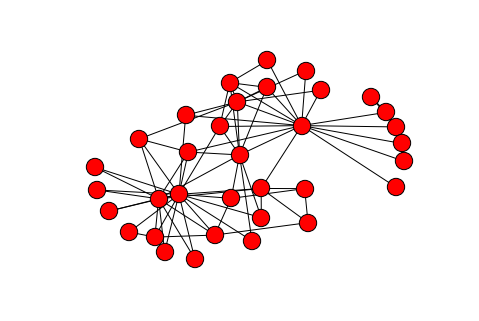

In [56]:
pos = nx.spring_layout(G)
nx.draw(G, pos)

In [57]:
def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    size = len(ys) // n
    leftovers= ys[size*n:]
    for c in xrange(n):
        if leftovers:
           extra= [ leftovers.pop() ] 
        else:
           extra= []
        yield ys[c*size:(c+1)*size] + extra

####Common neighbours
For a node x, let $\Gamma(x)$ denote the set of neighbors of $x$. In common sense, two nodes, $x$ and $y$, are more likely to have a link if they have many common neighbors. The simplest measure of this neighborhood overlap is the directed count, namely
$$s_{xy}^{CN} = |\Gamma(x) \cap \Gamma(y)|,$$
where $|Q|$ is the cardinality of the set $Q$. It is obvious that $s_{xy} = (A^2)_{xy}$, where $A$ is the adjacency matrix: $A_{xy} = 1$ if $x$ and $y$ are directly connected and $A_{xy} = 0$ otherwise. Note that, $(A^2)_{xy}$ is also the number of different paths with length 2 connecting $x$ and $y$. Newman [40] used this quantity in the study of collaboration networks, showing a positive correlation between the number of common neighbors and the probability that two scientists will collaborate in the future. Kossinets and Watts [14] analyzed a large-scale social network, suggesting that two students having many mutual friends are very probable to be friends in future. The following six indices are also based on the number of common neighbors, yet with different normalization methods.

In [58]:
folds = [i for i in chunk(G.edges(), 10)]

In [59]:
subs = []
for i in xrange(10):
    graph = G.copy()
    for c in folds[i]:
        graph.remove_edge(*c)
    subs.append(graph.copy())

In [60]:
def common_neighbours(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        edgesWithScore[(a, b)] = len(sorted(nx.common_neighbors(i, a, b)))
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        edgesWithScore[(a, b)] = len(sorted(nx.common_neighbors(i, a, b)))
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Salton Index
It is defined as
$$s_{xy}^{Salton} = \frac{|\Gamma(x) \cap \Gamma(y)|}{\sqrt{k_x \times k_x}}$$
where $k_x$ is the degree of node $x$. The Salton index is also called the cosine similarity in the literature.

In [61]:
def salton_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 and nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                np.sqrt(nx.degree(i, a) * nx.degree(i, b)))
                        else:
                            edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 and nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                np.sqrt(nx.degree(i, a) * nx.degree(i, b)))
                        else:
                            edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Jaccard Index
This index was proposed by Jaccard over a hundred years ago, and is defined as
$$s_{xy}^{Jaccard} = \frac{|\Gamma(x) \cap \Gamma(y)|}{|\Gamma(x) \cup \Gamma(y)|}$$

In [62]:
def jaccard_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 or nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                len(set(i[a])|set(i[b])))
                        else:
                            edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 or nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                len(set(i[a])|set(i[b])))
                        else:
                            edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Sorensen Index
This index is used mainly for ecological community data, and is defined as
$$s_{xy}^{Sorensen} = \frac{2|\Gamma(x) \cap \Gamma(y)|}{k_x + k_y}$$

In [63]:
def sorensen_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 or nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = 2*float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                nx.degree(i, a) + nx.degree(i, b))
                        else:
                            edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 or nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = 2*float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                nx.degree(i, a) + nx.degree(i, b))
                        else:
                            edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Hub Promoted Index (HPI)
This index is proposed for quantifying the topological overlap of pairs of substrates in metabolic networks, and is defined as
$$s_{xy}^{HPI} = \frac{|\Gamma(x) \cap \Gamma(y)|}{min\{k_x, k_y\}}$$
Under this measurement, the links adjacent to hubs are likely to be assigned high scores since the denominator is determined by the lower degree only.

In [64]:
def hub_promoted_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 and nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                min(nx.degree(i, a), nx.degree(i, b)))
                        else:
                            edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 and nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                min(nx.degree(i, a), nx.degree(i, b)))
                        else:
                            edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Hub Depressed Index (HDI)
Analogously to the above index, we also consider a measurement with the opposite effect on hubs, defined as
$$s_{xy}^{HDI} = \frac{|\Gamma(x) \cap \Gamma(y)|}{max\{k_x, k_y\}}$$

In [65]:
def hub_depressed_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 or nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                max(nx.degree(i, a), nx.degree(i, b)))
                        else:
                            edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 or nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                max(nx.degree(i, a), nx.degree(i, b)))
                        else:
                            edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Leicht–Holme–Newman Index (LHN1)
This index assigns high similarity to node pairs that have many common neighbors compared not to the possible maximum, but to the expected number of such neighbors. It is defined as
$$s_{xy}^{LHN1} = \frac{|\Gamma(x) \cap \Gamma(y)|}{k_x \times k_y}$$
where the denominator, $k_x \times k_y$, is proportional to the expected number of common neighbors of nodes $x$ and $y$ in the configuration model. We use the abbreviation LHN1 to distinguish this index to another index (named as LHN2 index) also proposed by Leicht, Holme and Newman.

In [66]:
def LHN1_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 and nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                nx.degree(i, a) * nx.degree(i, b))
                        else:
                            edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        if nx.degree(i, a) != 0 and nx.degree(i, b) != 0:
                            edgesWithScore[(a, b)] = float(len(sorted(nx.common_neighbors(i, a, b))))/float(
                                nx.degree(i, a) * nx.degree(i, b))
                        else:
                            edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Preferential Attachment Index (PA)
The mechanism of preferential attachment can be used to generate evolving scale- free networks, where the probability that a new link is connected to the node $x$ is proportional to $k_x$. A similar mechanism can also lead to scale-free networks without growth, where at each time step, an old link is removed and a new link is generated. The probability that this new link will connect $x$ and $y$ is proportional to $k_x \times k_y$. Motivated by this mechanism, the corresponding similarity index can be defined as
$$s_{xy}^{PA} = k_x \times k_y$$
which has been widely used to quantify the functional significance of links subject to various network-based dynamics, such as percolation, synchronization and transportation. Note that, this index does not require the information of the neighborhood of each node, as a consequence, it has the least computational complexity.

In [67]:
def preferential_attachment_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        edgesWithScore[(a, b)] = nx.degree(i, a) * nx.degree(i, b)
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if a != b and b not in i[a].keys() and a not in i[b].keys():
                        edgesWithScore[(a, b)] = nx.degree(i, a) * nx.degree(i, b)
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Adamic–Adar Index (AA)
This index refines the simple counting of common neighbors by assigning the less- connected neighbors more weights, and is defined as
$$s_{xy}^{AA} = \sum_{z \in \Gamma(x) \cap \Gamma(y)} \frac{1}{log k_z}$$

In [68]:
def adamic_adar_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if 0 not in nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values():
                        edgesWithScore[(a, b)] = np.sum(
                            1/np.log(nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values()))
                    else:
                        edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if 0 not in nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values():
                        edgesWithScore[(a, b)] = np.sum(
                            1/np.log(nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values()))
                    else:
                        edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

####Resource Allocation Index (RA)
This index is motivated by the resource allocation dynamics on complex networks. Consider a pair of nodes, $x$ and $y$, which are not directly connected. The node $x$ can send some resource to $y$, with their common neighbors playing the role of transmitters. In the simplest case, we assume that each transmitter has a unit of resource, and will equally distribute it to all its neighbors. The similarity between $x$ and $y$ can be defined as the amount of resource $y$ received from $x$, which is
$$s_{xy}^{RA} = \sum_{z \in \Gamma(x) \cap \Gamma(y)} \frac{1}{k_z}$$
Clearly,this measure is symmetric,namely $s_{xy} = s_{yx}$.Note that, although resulting from different motivations, the AA index and RA index have very similar form. Indeed, they both depress the contribution of the high-degree common neighbors. AA index takes the form $(log k )^{−1}$ while RA index takes the form $k^{−1}$. The difference is insignificant when the degree, $k_z$, is small, while it is considerable when $k_z$ is large. In other words, RA index punishes the high-degree common neighbors more heavily than AA.

In [69]:
def resourse_allocation_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    precision = []
    for i in subs:
        edgesWithScore = {}
        edges = []
        if symmetric:
            for a in i.nodes():
                for b in i.nodes()[a+1:]:
                    if 0 not in nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values():
                        edgesWithScore[(a, b)] = np.sum(
                            1/np.array(nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values()).astype(float))
                    else:
                        edgesWithScore[(a, b)] = 0
        else:
            for a in i.nodes():
                for b in i.nodes():
                    if 0 not in nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values():
                        edgesWithScore[(a, b)] = np.sum(
                            1/np.array(nx.degree(i, sorted(nx.common_neighbors(i, a, b))).values()).astype(float))
                    else:
                        edgesWithScore[(a, b)] = 0
        edgesWithScoreSorted = sorted(edgesWithScore.items(), key=operator.itemgetter(1), reverse = True)
        for c in edgesWithScoreSorted:
            edges.append((c[0][0], c[0][1]))
        currentPrecision = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        precision.append(float(len(set(folds[step]) & set(edges[0:nmis])))/float(len(folds[step])))
        step += 1
        
    #print 'Mean AUC =', np.mean(auc)
    #print 'Mean precision =', np.mean(precision)
    return np.mean(auc)

In [70]:
def run_local_similarity_indices(G, symmetric = True, nfolds = 10, seed = 0):
    random.seed(seed)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    cn = common_neighbours(folds, subs, symmetric = symmetric)
    print 'cn'
    sai = salton_index(folds, subs, symmetric = symmetric)
    print 'sai'
    ji = jaccard_index(folds, subs, symmetric = symmetric)
    print 'ji'
    soi = sorensen_index(folds, subs, symmetric = symmetric)
    print 'soi'
    hpi = hub_promoted_index(folds, subs, symmetric = symmetric)
    print 'hpi'
    hdi = hub_depressed_index(folds, subs, symmetric = symmetric)
    print 'hdi'
    lhn1 = LHN1_index(folds, subs, symmetric = symmetric)
    print 'LHN1'
    pai = preferential_attachment_index(folds, subs, symmetric = symmetric)
    print 'pai'
    aai = adamic_adar_index(folds, subs, symmetric = symmetric)
    print 'aai'
    rai = resourse_allocation_index(folds, subs, symmetric = symmetric)
    print 'rai'
    aucs = {'CN' : cn, 
            'SaI' : sai, 
            'JI' : ji, 
            'SoI' : soi,
            'HPI' : hpi,
            'HDI' : hdi,
            'LHN1' : lhn1,
            'PAI' : pai,
            'AAI' : aai,
            'RAI' : rai}
    return aucs

In [71]:
df = pd.DataFrame(run_local_similarity_indices(nx.karate_club_graph()), index = ['karate club'])

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [72]:
df

,AAI,CN,HDI,HPI,JI,LHN1,PAI,RAI,SaI,SoI
karate club,0.69818,0.699908,0.592641,0.712276,0.606829,0.599922,0.711626,0.704699,0.636143,0.606829


In [73]:
pajek_football = nx.read_pajek('./netws/pajekds/football.net')

In [74]:
fixed_pajek_football = nx.Graph(nx.convert_node_labels_to_integers(pajek_football, first_label = 0))

In [75]:
df.loc['pajec_football'] = run_local_similarity_indices(fixed_pajek_football, symmetric = False)

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [76]:
df

,AAI,CN,HDI,HPI,JI,LHN1,PAI,RAI,SaI,SoI
karate club,0.698180,0.699908,0.592641,0.712276,0.606829,0.599922,0.711626,0.704699,0.636143,0.606829
pajec_football,0.612595,0.660073,0.577434,0.598886,0.586123,0.490986,0.751823,0.607038,0.587751,0.586123


In [77]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')

In [78]:
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))

In [79]:
df.loc['pajek_us_air'] = run_local_similarity_indices(fixed_pajek_us_air, symmetric = True)

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [80]:
df

,AAI,CN,HDI,HPI,JI,LHN1,PAI,RAI,SaI,SoI
karate club,0.698180,0.699908,0.592641,0.712276,0.606829,0.599922,0.711626,0.704699,0.636143,0.606829
pajec_football,0.612595,0.660073,0.577434,0.598886,0.586123,0.490986,0.751823,0.607038,0.587751,0.586123
pajek_us_air,0.930252,0.934896,0.891644,0.870076,0.898030,0.767659,0.886947,0.935874,0.908560,0.898030
